In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import torch
import numpy as np
from matplotlib import pyplot as plt
from data import PVDataGenerator, PVDataLoader
from data.utils import cross_val_fold, train_test_split_fold
# from hypertuning import BetaQPGPOneDim

In [2]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 365
N_DAYS_TRAIN = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 300
RADIUS = 0.35
CIRCLE_COORDS = (55, -1.5)
# create a tuple of 4 coordinates that form a polygon in the uk

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [3]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=POLY_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='poly',
                    drop_nan=False)

X, y = generator.get_time_series()

==> Loading data
==> Loaded data in: 0 m : 8 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [4]:
print(y.shape)

torch.Size([35040, 300])


In [5]:
x_list, y_list = cross_val_fold(X, y, N_DAYS_TRAIN, DAILY_DATA_POINTS)
x_train, y_train, x_test, y_test =  train_test_split_fold(x_list, y_list, N_HOURS_PRED, DAILY_DATA_POINTS, DAY_MIN, DAY_MAX)

In [ ]:
train_loader = PVDataLoader(x_train, y_train)
test_loader = PVDataLoader(x_test, y_test)

In [ ]:
x_tr_winter, y_tr_winter, x_te_winter, y_te_winter = [],[],[],[]
x_tr_spring, y_tr_spring, x_te_spring, y_te_spring = [],[],[],[]
x_tr_summer, y_tr_summer, x_te_summer, y_te_summer = [],[],[],[]
x_tr_fall, y_tr_fall, x_te_fall, y_te_fall = [],[],[],[]

# use the lists that has 73 elements with five days of in consecutive order to fill in the lists
# winter is the first 365/(5*4) = 18, spring is the next 18, summer, fall, etc.

for i, ((x_tr, y_tr), (x_te, y_te)) in enumerate(zip(train_loader, test_loader)):

    idx = np.random.randint(0, y_tr.size(-1), y_tr.size(-1), replace=False)
    # winter indices
    if i < 12 or i > 75 - 4:

        x_tr_winter.append(x_tr)
        y_tr_winter.append(y_tr[:,idx])
        x_te_winter.append(x_te)
        y_te_winter.append(y_te[:,idx])
    
    # spring indices
    elif i < 20:
        x_tr_spring.append(x_tr)
        y_tr_spring.append(y_tr[:,idx])
        x_te_spring.append(x_te)
        y_te_spring.append(y_te[:,idx])
    
    elif i < 48:
        x_tr_summer.append(x_tr)
        y_tr_summer.append(y_tr[:,idx])
        x_te_summer.append(x_te)
        y_te_summer.append(y_te[:,idx])
    
    elif i < 66:
        x_tr_fall.append(x_tr)
        y_tr_fall.append(y_tr[:,idx])
        x_te_fall.append(x_te)
        y_te_fall.append(y_te[:,idx])
    
    else:
        # winter indices
        x_tr_winter.append(x_tr)
        y_tr_winter.append(y_tr[:,idx])
        x_te_winter.append(x_te)
        y_te_winter.append(y_te[:,idx])

In [ ]:
train_loader_w = PVDataLoader(x_tr_winter, y_tr_winter)
test_loader_w = PVDataLoader(x_te_winter, y_te_winter)

train_loader_sp = PVDataLoader(x_tr_spring, y_tr_spring)
test_loader_sp = PVDataLoader(x_te_spring, y_te_spring)

train_loader_su = PVDataLoader(x_tr_summer, y_tr_summer)
test_loader_su = PVDataLoader(x_te_summer, y_te_summer)

train_loader_f = PVDataLoader(x_tr_fall, y_tr_fall)
test_loader_f = PVDataLoader(x_te_fall, y_te_fall)


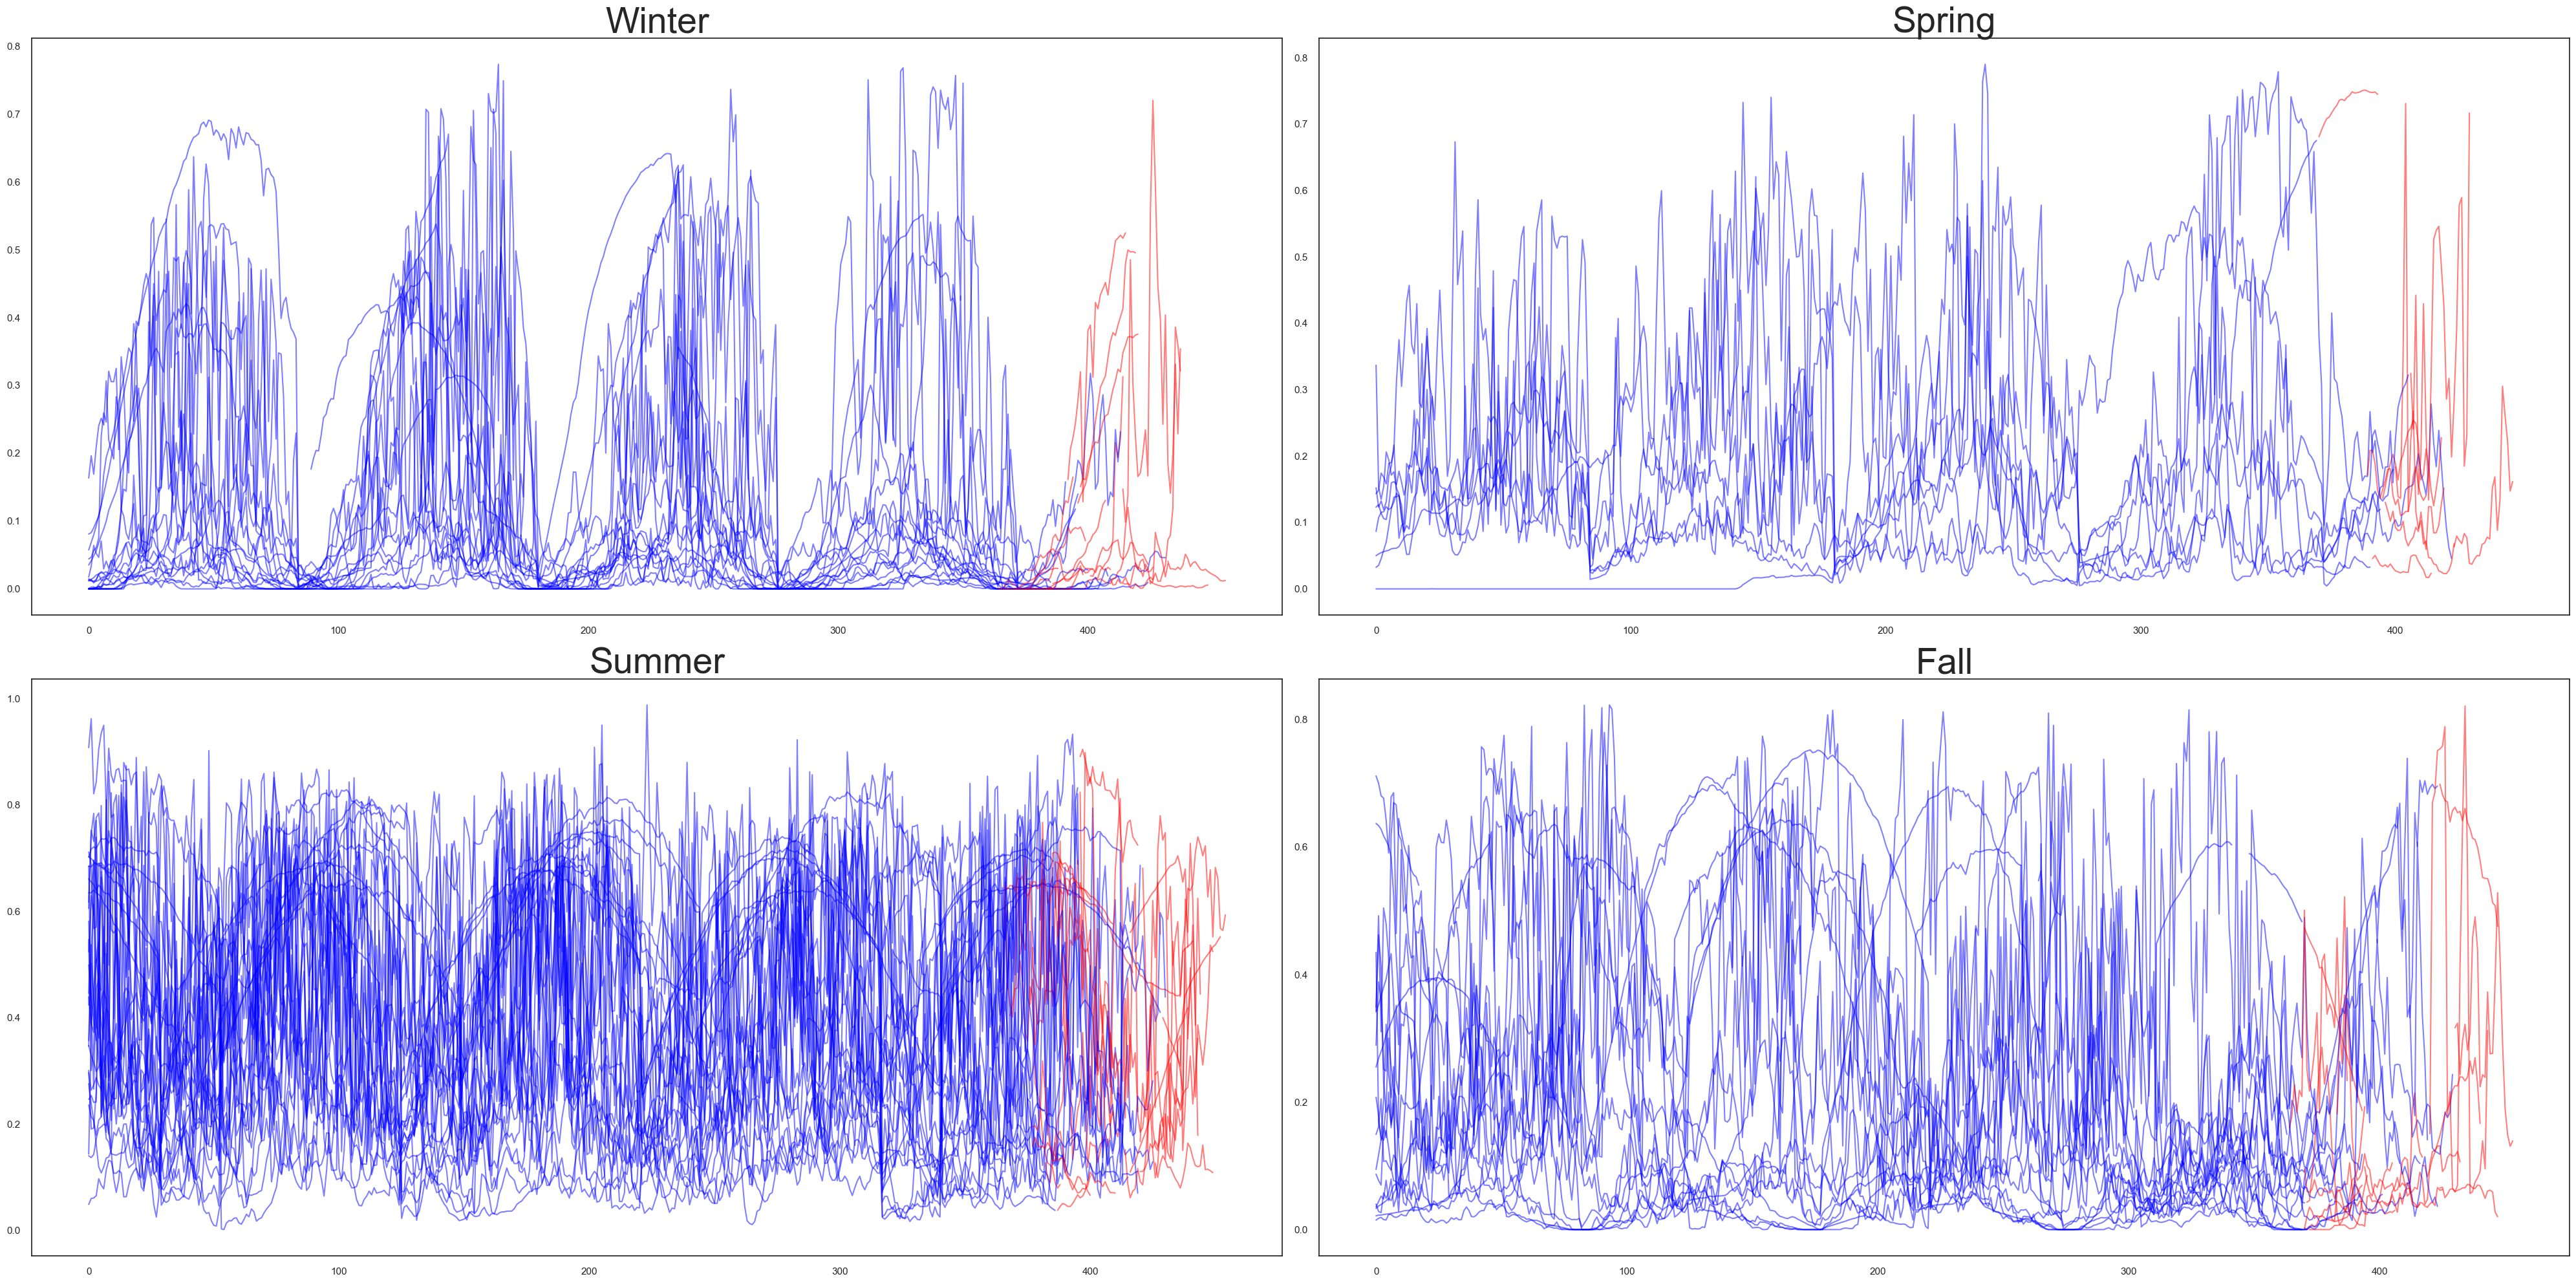

In [10]:
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2, 2, figsize=(40, 20))


alpha = 0.5
ax = ax.flatten()
for (x_tr, y_tr), (x_te, y_te) in zip(train_loader_w, test_loader_w):
    for i in range(y_tr.shape[1]):
        t_train = torch.arange(y_tr.shape[0])
        t_test = torch.arange(y_tr.shape[0], y_te.shape[0] + y_tr.shape[0])
        ax[0].plot(t_train, y_tr[:,i], color='blue', alpha=alpha)
        ax[0].plot(t_test, y_te[:,i], color='red', alpha=alpha)
    ax[0].set_title('Winter', fontsize=40)

for (x_tr, y_tr), (x_te, y_te) in zip(train_loader_sp, test_loader_sp):
    for i in range(y_tr.shape[1]):
        t_train = torch.arange(y_tr.shape[0])
        t_test = torch.arange(y_tr.shape[0], y_te.shape[0] + y_tr.shape[0])
        ax[1].plot(t_train, y_tr[:,i], color='blue', alpha=alpha)
        ax[1].plot(t_test, y_te[:,i], color='red', alpha=alpha)
    ax[1].set_title('Spring', fontsize=40)

for (x_tr, y_tr), (x_te, y_te) in zip(train_loader_su, test_loader_su):
    for i in range(y_tr.shape[1]):
        t_train = torch.arange(y_tr.shape[0])
        t_test = torch.arange(y_tr.shape[0], y_te.shape[0] + y_tr.shape[0])
        ax[2].plot(t_train, y_tr[:,i], color='blue', alpha=alpha)
        ax[2].plot(t_test, y_te[:,i], color='red', alpha=alpha)
    ax[2].set_title('Summer', fontsize=40)

for (x_tr, y_tr), (x_te, y_te) in zip(train_loader_f, test_loader_f):
    for i in range(y_tr.shape[1]):
        t_train = torch.arange(y_tr.shape[0])
        t_test = torch.arange(y_tr.shape[0], y_te.shape[0] + y_tr.shape[0])
        ax[3].plot(t_train, y_tr[:,i], color='blue', alpha=alpha)
        ax[3].plot(t_test, y_te[:,i], color='red', alpha=alpha)
    ax[3].set_title('Fall', fontsize=40)

plt.tight_layout()
plt.show()

In [11]:
model_winter = BetaQPGPOneDim(train_loader=train_loader_w, test_loader=test_loader_w)

In [12]:
model_winter.run_study(n_trials=100, direction='minimize')

[I 2023-07-29 11:21:51,789] A new study created in memory with name: no-name-b478e696-7e57-4115-9c92-f84c80686006


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 3:55.7 (0.07/s) 


[I 2023-07-29 11:25:47,636] Trial 0 finished with value: -0.023935463279485703 and parameters: {'alpha_matern': 2, 'beta_matern': 9, 'alpha_periodic': 8, 'beta_periodic': 4, 'alpha_periodic_P': 10, 'beta_periodic_P': 4, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 0 with value: -0.023935463279485703.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:07.4 (0.06/s) 


[I 2023-07-29 11:29:55,092] Trial 1 finished with value: -0.025149201974272728 and parameters: {'alpha_matern': 8, 'beta_matern': 14, 'alpha_periodic': 8, 'beta_periodic': 10, 'alpha_periodic_P': 4, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:19.1 (0.06/s) 


[I 2023-07-29 11:34:14,304] Trial 2 finished with value: 0.07537432760000229 and parameters: {'alpha_matern': 1, 'beta_matern': 15, 'alpha_periodic': 6, 'beta_periodic': 3, 'alpha_periodic_P': 2, 'beta_periodic_P': 9, 'mean_type': 'zero', 'scale': 16, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:21.7 (0.05/s) 


[I 2023-07-29 11:39:36,069] Trial 3 finished with value: 0.049864038825035095 and parameters: {'alpha_matern': 5, 'beta_matern': 14, 'alpha_periodic': 3, 'beta_periodic': 2, 'alpha_periodic_P': 2, 'beta_periodic_P': 7, 'mean_type': 'constant', 'scale': 11, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:26.8 (0.05/s) 


[I 2023-07-29 11:45:03,018] Trial 4 finished with value: 0.060412902384996414 and parameters: {'alpha_matern': 3, 'beta_matern': 10, 'alpha_periodic': 1, 'beta_periodic': 4, 'alpha_periodic_P': 8, 'beta_periodic_P': 2, 'mean_type': 'zero', 'scale': 6, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:56.1 (0.05/s) 


[I 2023-07-29 11:49:59,200] Trial 5 finished with value: 0.04618917033076286 and parameters: {'alpha_matern': 9, 'beta_matern': 13, 'alpha_periodic': 9, 'beta_periodic': 1, 'alpha_periodic_P': 9, 'beta_periodic_P': 4, 'mean_type': 'constant', 'scale': 11, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:21.9 (0.05/s) 


[I 2023-07-29 11:55:21,156] Trial 6 finished with value: 0.03326570987701416 and parameters: {'alpha_matern': 9, 'beta_matern': 8, 'alpha_periodic': 4, 'beta_periodic': 9, 'alpha_periodic_P': 3, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 6, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:37.8 (0.06/s) 


[I 2023-07-29 11:59:59,052] Trial 7 finished with value: 0.057649269700050354 and parameters: {'alpha_matern': 9, 'beta_matern': 8, 'alpha_periodic': 7, 'beta_periodic': 3, 'alpha_periodic_P': 1, 'beta_periodic_P': 5, 'mean_type': 'zero', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:49.5 (0.06/s) 


[I 2023-07-29 12:04:48,647] Trial 8 finished with value: 0.04615866392850876 and parameters: {'alpha_matern': 8, 'beta_matern': 8, 'alpha_periodic': 4, 'beta_periodic': 10, 'alpha_periodic_P': 9, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:53.7 (0.05/s) 


[I 2023-07-29 12:09:42,420] Trial 9 finished with value: 0.03854282200336456 and parameters: {'alpha_matern': 3, 'beta_matern': 10, 'alpha_periodic': 7, 'beta_periodic': 2, 'alpha_periodic_P': 7, 'beta_periodic_P': 1, 'mean_type': 'constant', 'scale': 11, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:52.0 (0.05/s) 


[I 2023-07-29 12:14:34,614] Trial 10 finished with value: 0.04585068300366402 and parameters: {'alpha_matern': 6, 'beta_matern': 12, 'alpha_periodic': 10, 'beta_periodic': 7, 'alpha_periodic_P': 5, 'beta_periodic_P': 7, 'mean_type': 'zero', 'scale': 1, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 3:58.5 (0.07/s) 


[I 2023-07-29 12:18:33,210] Trial 11 finished with value: 0.038172077387571335 and parameters: {'alpha_matern': 6, 'beta_matern': 5, 'alpha_periodic': 8, 'beta_periodic': 6, 'alpha_periodic_P': 5, 'beta_periodic_P': 3, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:40.8 (0.06/s) 


[I 2023-07-29 12:23:14,152] Trial 12 finished with value: 0.03301503136754036 and parameters: {'alpha_matern': 7, 'beta_matern': 12, 'alpha_periodic': 10, 'beta_periodic': 8, 'alpha_periodic_P': 6, 'beta_periodic_P': 7, 'mean_type': 'constant', 'scale': 6, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:41.9 (0.06/s) 


[I 2023-07-29 12:27:56,255] Trial 13 finished with value: 0.028571030125021935 and parameters: {'alpha_matern': 4, 'beta_matern': 6, 'alpha_periodic': 8, 'beta_periodic': 5, 'alpha_periodic_P': 10, 'beta_periodic_P': 3, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:42.8 (0.05/s) 


[I 2023-07-29 12:33:39,211] Trial 14 finished with value: 0.024479998275637627 and parameters: {'alpha_matern': 1, 'beta_matern': 11, 'alpha_periodic': 6, 'beta_periodic': 6, 'alpha_periodic_P': 4, 'beta_periodic_P': 6, 'mean_type': 'constant', 'scale': 6, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:15.4 (0.04/s) 


[I 2023-07-29 12:39:54,803] Trial 15 finished with value: 0.021060124039649963 and parameters: {'alpha_matern': 10, 'beta_matern': 15, 'alpha_periodic': 8, 'beta_periodic': 10, 'alpha_periodic_P': 7, 'beta_periodic_P': 4, 'mean_type': 'constant', 'scale': 11, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:19.1 (0.04/s) 


[I 2023-07-29 12:46:14,039] Trial 16 finished with value: 0.017690233886241913 and parameters: {'alpha_matern': 2, 'beta_matern': 9, 'alpha_periodic': 9, 'beta_periodic': 8, 'alpha_periodic_P': 4, 'beta_periodic_P': 6, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:51.5 (0.04/s) 


[I 2023-07-29 12:53:05,708] Trial 17 finished with value: 0.01546055730432272 and parameters: {'alpha_matern': 7, 'beta_matern': 7, 'alpha_periodic': 5, 'beta_periodic': 5, 'alpha_periodic_P': 10, 'beta_periodic_P': 1, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 8:34.0 (0.03/s) 


[I 2023-07-29 13:01:39,980] Trial 18 finished with value: 0.02309359796345234 and parameters: {'alpha_matern': 5, 'beta_matern': 13, 'alpha_periodic': 7, 'beta_periodic': 4, 'alpha_periodic_P': 6, 'beta_periodic_P': 4, 'mean_type': 'zero', 'scale': 11, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 7:54.0 (0.03/s) 


[I 2023-07-29 13:09:34,248] Trial 19 finished with value: 0.02048565074801445 and parameters: {'alpha_matern': 4, 'beta_matern': 11, 'alpha_periodic': 9, 'beta_periodic': 7, 'alpha_periodic_P': 4, 'beta_periodic_P': 8, 'mean_type': 'constant', 'scale': 6, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 8:44.7 (0.03/s) 


[I 2023-07-29 13:18:19,644] Trial 20 finished with value: 0.018364369869232178 and parameters: {'alpha_matern': 7, 'beta_matern': 9, 'alpha_periodic': 1, 'beta_periodic': 4, 'alpha_periodic_P': 7, 'beta_periodic_P': 3, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:59.1 (0.04/s) 


[I 2023-07-29 13:24:19,982] Trial 21 finished with value: 0.016145404428243637 and parameters: {'alpha_matern': 7, 'beta_matern': 6, 'alpha_periodic': 5, 'beta_periodic': 5, 'alpha_periodic_P': 10, 'beta_periodic_P': 1, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:36.2 (0.04/s) 


[I 2023-07-29 13:30:56,444] Trial 22 finished with value: 0.014495297335088253 and parameters: {'alpha_matern': 8, 'beta_matern': 7, 'alpha_periodic': 5, 'beta_periodic': 5, 'alpha_periodic_P': 9, 'beta_periodic_P': 2, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:24.6 (0.04/s) 


[I 2023-07-29 13:37:21,242] Trial 23 finished with value: 0.012471362017095089 and parameters: {'alpha_matern': 8, 'beta_matern': 7, 'alpha_periodic': 3, 'beta_periodic': 7, 'alpha_periodic_P': 9, 'beta_periodic_P': 2, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:34.9 (0.05/s) 


[I 2023-07-29 13:42:56,340] Trial 24 finished with value: 0.010486874729394913 and parameters: {'alpha_matern': 10, 'beta_matern': 9, 'alpha_periodic': 2, 'beta_periodic': 9, 'alpha_periodic_P': 8, 'beta_periodic_P': 2, 'mean_type': 'constant', 'scale': 11, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:40.6 (0.06/s) 


[I 2023-07-29 13:47:37,185] Trial 25 finished with value: 0.009313078597187996 and parameters: {'alpha_matern': 10, 'beta_matern': 11, 'alpha_periodic': 2, 'beta_periodic': 9, 'alpha_periodic_P': 8, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 11, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:19.9 (0.06/s) 


[I 2023-07-29 13:51:57,259] Trial 26 finished with value: 0.014604108408093452 and parameters: {'alpha_matern': 10, 'beta_matern': 11, 'alpha_periodic': 7, 'beta_periodic': 9, 'alpha_periodic_P': 3, 'beta_periodic_P': 5, 'mean_type': 'zero', 'scale': 11, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 3:25.2 (0.08/s) 


[I 2023-07-29 13:55:22,580] Trial 27 finished with value: 0.013140403665602207 and parameters: {'alpha_matern': 9, 'beta_matern': 14, 'alpha_periodic': 2, 'beta_periodic': 10, 'alpha_periodic_P': 8, 'beta_periodic_P': 6, 'mean_type': 'constant', 'scale': 6, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 3:23.7 (0.08/s) 


[I 2023-07-29 13:58:46,364] Trial 28 finished with value: 0.011718297377228737 and parameters: {'alpha_matern': 10, 'beta_matern': 12, 'alpha_periodic': 6, 'beta_periodic': 8, 'alpha_periodic_P': 6, 'beta_periodic_P': 4, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 3:20.5 (0.08/s) 


[I 2023-07-29 14:02:06,970] Trial 29 finished with value: 0.018462441861629486 and parameters: {'alpha_matern': 1, 'beta_matern': 14, 'alpha_periodic': 6, 'beta_periodic': 9, 'alpha_periodic_P': 10, 'beta_periodic_P': 5, 'mean_type': 'zero', 'scale': 11, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 3:21.6 (0.08/s) 


[I 2023-07-29 14:05:28,769] Trial 30 finished with value: 0.017173292115330696 and parameters: {'alpha_matern': 8, 'beta_matern': 13, 'alpha_periodic': 8, 'beta_periodic': 3, 'alpha_periodic_P': 8, 'beta_periodic_P': 8, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:27.6 (0.06/s) 


[I 2023-07-29 14:09:56,467] Trial 31 finished with value: 0.015454757027328014 and parameters: {'alpha_matern': 10, 'beta_matern': 9, 'alpha_periodic': 2, 'beta_periodic': 9, 'alpha_periodic_P': 8, 'beta_periodic_P': 3, 'mean_type': 'constant', 'scale': 11, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:10.3 (0.05/s) 


[I 2023-07-29 14:15:06,911] Trial 32 finished with value: 0.014349224977195263 and parameters: {'alpha_matern': 9, 'beta_matern': 15, 'alpha_periodic': 2, 'beta_periodic': 10, 'alpha_periodic_P': 7, 'beta_periodic_P': 4, 'mean_type': 'constant', 'scale': 11, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:52.6 (0.05/s) 


[I 2023-07-29 14:19:59,634] Trial 33 finished with value: 0.012829422950744629 and parameters: {'alpha_matern': 10, 'beta_matern': 10, 'alpha_periodic': 3, 'beta_periodic': 8, 'alpha_periodic_P': 3, 'beta_periodic_P': 2, 'mean_type': 'constant', 'scale': 11, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:27.9 (0.05/s) 


[I 2023-07-29 14:25:27,700] Trial 34 finished with value: 0.011791422963142395 and parameters: {'alpha_matern': 2, 'beta_matern': 10, 'alpha_periodic': 1, 'beta_periodic': 9, 'alpha_periodic_P': 9, 'beta_periodic_P': 6, 'mean_type': 'constant', 'scale': 6, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:17.9 (0.05/s) 


[I 2023-07-29 14:30:45,876] Trial 35 finished with value: 0.010332036763429642 and parameters: {'alpha_matern': 9, 'beta_matern': 9, 'alpha_periodic': 2, 'beta_periodic': 10, 'alpha_periodic_P': 5, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 11, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:53.2 (0.05/s) 


[I 2023-07-29 14:35:39,241] Trial 36 finished with value: 0.01369031984359026 and parameters: {'alpha_matern': 9, 'beta_matern': 11, 'alpha_periodic': 4, 'beta_periodic': 10, 'alpha_periodic_P': 5, 'beta_periodic_P': 5, 'mean_type': 'zero', 'scale': 6, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


on 5: Not PSD error, skip nr.: 1
on 6: Not PSD error, skip nr.: 2
on 6: Not PSD error, skip nr.: 3
|███████████████████████████▍⚠︎           | (!) 13/19 [68%] in 4:41.5 (0.05/s) 


[I 2023-07-29 14:40:20,892] Trial 37 finished with value: 0.012433275580406189 and parameters: {'alpha_matern': 8, 'beta_matern': 8, 'alpha_periodic': 9, 'beta_periodic': 10, 'alpha_periodic_P': 1, 'beta_periodic_P': 4, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:26.7 (0.05/s) 


[I 2023-07-29 14:45:47,711] Trial 38 finished with value: 0.011240319348871708 and parameters: {'alpha_matern': 9, 'beta_matern': 13, 'alpha_periodic': 3, 'beta_periodic': 2, 'alpha_periodic_P': 2, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 11, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:53.4 (0.05/s) 


[I 2023-07-29 14:50:41,246] Trial 39 finished with value: 0.009875125251710415 and parameters: {'alpha_matern': 4, 'beta_matern': 8, 'alpha_periodic': 4, 'beta_periodic': 4, 'alpha_periodic_P': 4, 'beta_periodic_P': 7, 'mean_type': 'constant', 'scale': 6, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:50.5 (0.06/s) 


[I 2023-07-29 14:55:31,874] Trial 40 finished with value: 0.011938848532736301 and parameters: {'alpha_matern': 4, 'beta_matern': 8, 'alpha_periodic': 3, 'beta_periodic': 4, 'alpha_periodic_P': 2, 'beta_periodic_P': 10, 'mean_type': 'zero', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:52.7 (0.05/s) 


[I 2023-07-29 15:00:22,739] Trial 41 finished with value: 0.010845402255654335 and parameters: {'alpha_matern': 3, 'beta_matern': 9, 'alpha_periodic': 1, 'beta_periodic': 1, 'alpha_periodic_P': 4, 'beta_periodic_P': 7, 'mean_type': 'constant', 'scale': 6, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:06.1 (0.07/s) 


[I 2023-07-29 15:04:28,946] Trial 42 finished with value: 0.009833138436079025 and parameters: {'alpha_matern': 2, 'beta_matern': 10, 'alpha_periodic': 4, 'beta_periodic': 3, 'alpha_periodic_P': 5, 'beta_periodic_P': 8, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:32.7 (0.06/s) 


[I 2023-07-29 15:09:01,782] Trial 43 finished with value: 0.008738401345908642 and parameters: {'alpha_matern': 2, 'beta_matern': 10, 'alpha_periodic': 4, 'beta_periodic': 3, 'alpha_periodic_P': 3, 'beta_periodic_P': 9, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:50.1 (0.06/s) 


[I 2023-07-29 15:13:51,944] Trial 44 finished with value: 0.007821415551006794 and parameters: {'alpha_matern': 2, 'beta_matern': 10, 'alpha_periodic': 4, 'beta_periodic': 3, 'alpha_periodic_P': 3, 'beta_periodic_P': 9, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:41.5 (0.06/s) 


[I 2023-07-29 15:18:33,596] Trial 45 finished with value: 0.0069307298399508 and parameters: {'alpha_matern': 2, 'beta_matern': 10, 'alpha_periodic': 5, 'beta_periodic': 2, 'alpha_periodic_P': 3, 'beta_periodic_P': 9, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:12.8 (0.05/s) 


[I 2023-07-29 15:23:46,560] Trial 46 finished with value: 0.005947551224380732 and parameters: {'alpha_matern': 2, 'beta_matern': 10, 'alpha_periodic': 5, 'beta_periodic': 2, 'alpha_periodic_P': 3, 'beta_periodic_P': 9, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:09.3 (0.05/s) 


[I 2023-07-29 15:28:56,017] Trial 47 finished with value: 0.005285738501697779 and parameters: {'alpha_matern': 1, 'beta_matern': 12, 'alpha_periodic': 5, 'beta_periodic': 2, 'alpha_periodic_P': 2, 'beta_periodic_P': 9, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:59.7 (0.05/s) 


[I 2023-07-29 15:33:57,954] Trial 48 finished with value: 0.0033172357361763716 and parameters: {'alpha_matern': 1, 'beta_matern': 12, 'alpha_periodic': 6, 'beta_periodic': 1, 'alpha_periodic_P': 2, 'beta_periodic_P': 9, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:57.5 (0.05/s) 


[I 2023-07-29 15:38:55,609] Trial 49 finished with value: 0.002567280549556017 and parameters: {'alpha_matern': 1, 'beta_matern': 12, 'alpha_periodic': 7, 'beta_periodic': 1, 'alpha_periodic_P': 1, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:06.1 (0.05/s) 


[I 2023-07-29 15:44:01,849] Trial 50 finished with value: 0.005454895086586475 and parameters: {'alpha_matern': 1, 'beta_matern': 12, 'alpha_periodic': 7, 'beta_periodic': 1, 'alpha_periodic_P': 1, 'beta_periodic_P': 10, 'mean_type': 'zero', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:57.9 (0.05/s) 


[I 2023-07-29 15:48:59,921] Trial 51 finished with value: 0.00806779321283102 and parameters: {'alpha_matern': 1, 'beta_matern': 12, 'alpha_periodic': 7, 'beta_periodic': 1, 'alpha_periodic_P': 1, 'beta_periodic_P': 10, 'mean_type': 'zero', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:05.8 (0.05/s) 


[I 2023-07-29 15:54:05,881] Trial 52 finished with value: 0.010453730821609497 and parameters: {'alpha_matern': 1, 'beta_matern': 12, 'alpha_periodic': 8, 'beta_periodic': 1, 'alpha_periodic_P': 2, 'beta_periodic_P': 10, 'mean_type': 'zero', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:55.3 (0.04/s) 


[I 2023-07-29 16:01:01,404] Trial 53 finished with value: 0.012818957678973675 and parameters: {'alpha_matern': 1, 'beta_matern': 14, 'alpha_periodic': 7, 'beta_periodic': 1, 'alpha_periodic_P': 1, 'beta_periodic_P': 10, 'mean_type': 'zero', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:56.5 (0.04/s) 


[I 2023-07-29 16:07:58,133] Trial 54 finished with value: 0.01567394658923149 and parameters: {'alpha_matern': 3, 'beta_matern': 12, 'alpha_periodic': 7, 'beta_periodic': 1, 'alpha_periodic_P': 1, 'beta_periodic_P': 9, 'mean_type': 'zero', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 7:03.8 (0.04/s) 


[I 2023-07-29 16:15:02,206] Trial 55 finished with value: 0.01836306042969227 and parameters: {'alpha_matern': 1, 'beta_matern': 13, 'alpha_periodic': 6, 'beta_periodic': 2, 'alpha_periodic_P': 2, 'beta_periodic_P': 10, 'mean_type': 'zero', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 7:26.4 (0.04/s) 


[I 2023-07-29 16:22:28,882] Trial 56 finished with value: 0.017656581476330757 and parameters: {'alpha_matern': 1, 'beta_matern': 13, 'alpha_periodic': 8, 'beta_periodic': 1, 'alpha_periodic_P': 1, 'beta_periodic_P': 8, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:28.8 (0.04/s) 


[I 2023-07-29 16:28:57,934] Trial 57 finished with value: 0.016806136816740036 and parameters: {'alpha_matern': 3, 'beta_matern': 15, 'alpha_periodic': 8, 'beta_periodic': 2, 'alpha_periodic_P': 2, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


on 0: Not PSD error, skip nr.: 1
on 0: Not PSD error, skip nr.: 2
on 0: Not PSD error, skip nr.: 3
on 0: Not PSD error, skip nr.: 4
on 0: Not PSD error, skip nr.: 5
on 0: Not PSD error, skip nr.: 6
on 0: Not PSD error, skip nr.: 7
on 0: Not PSD error, skip nr.: 8
on 0: Not PSD error, skip nr.: 9
on 0: Not PSD error, skip nr.: 10
on 0: Not PSD error, skip nr.: 11
on 0: Not PSD error, skip nr.: 12
on 0: Not PSD error, skip nr.: 13
on 0: Not PSD error, skip nr.: 14
on 0: Not PSD error, skip nr.: 15
on 0: Not PSD error, skip nr.: 16
|⚠︎                                       | (!) 0/19 [0%] in 29.6s (0.00/s) 


[I 2023-07-29 16:29:27,790] Trial 58 finished with value: 0.016806136816740036 and parameters: {'alpha_matern': 1, 'beta_matern': 11, 'alpha_periodic': 6, 'beta_periodic': 1, 'alpha_periodic_P': 1, 'beta_periodic_P': 9, 'mean_type': 'zero', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:29.8 (0.04/s) 


[I 2023-07-29 16:35:57,752] Trial 59 finished with value: 0.016186296939849854 and parameters: {'alpha_matern': 6, 'beta_matern': 13, 'alpha_periodic': 9, 'beta_periodic': 2, 'alpha_periodic_P': 2, 'beta_periodic_P': 8, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:48.5 (0.04/s) 


[I 2023-07-29 16:42:46,425] Trial 60 finished with value: 0.015309350565075874 and parameters: {'alpha_matern': 1, 'beta_matern': 14, 'alpha_periodic': 7, 'beta_periodic': 6, 'alpha_periodic_P': 2, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 6, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 7:13.7 (0.04/s) 


[I 2023-07-29 16:50:00,502] Trial 61 finished with value: 0.014667504467070103 and parameters: {'alpha_matern': 2, 'beta_matern': 11, 'alpha_periodic': 5, 'beta_periodic': 2, 'alpha_periodic_P': 3, 'beta_periodic_P': 9, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


on 0: Not PSD error, skip nr.: 1
|███████████████████████████████▋⚠︎       | (!) 15/19 [79%] in 6:08.6 (0.04/s) 


[I 2023-07-29 16:56:09,357] Trial 62 finished with value: 0.01407315582036972 and parameters: {'alpha_matern': 2, 'beta_matern': 12, 'alpha_periodic': 6, 'beta_periodic': 2, 'alpha_periodic_P': 1, 'beta_periodic_P': 9, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:11.2 (0.04/s) 


[I 2023-07-29 17:02:20,704] Trial 63 finished with value: 0.013389640487730503 and parameters: {'alpha_matern': 3, 'beta_matern': 12, 'alpha_periodic': 10, 'beta_periodic': 1, 'alpha_periodic_P': 2, 'beta_periodic_P': 9, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:15.1 (0.04/s) 


[I 2023-07-29 17:08:35,925] Trial 64 finished with value: 0.012629291974008083 and parameters: {'alpha_matern': 1, 'beta_matern': 11, 'alpha_periodic': 6, 'beta_periodic': 2, 'alpha_periodic_P': 4, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:53.7 (0.04/s) 


[I 2023-07-29 17:15:29,952] Trial 65 finished with value: 0.012009554542601109 and parameters: {'alpha_matern': 5, 'beta_matern': 14, 'alpha_periodic': 5, 'beta_periodic': 3, 'alpha_periodic_P': 2, 'beta_periodic_P': 8, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 7:11.8 (0.04/s) 


[I 2023-07-29 17:22:42,415] Trial 66 finished with value: 0.011362052522599697 and parameters: {'alpha_matern': 2, 'beta_matern': 11, 'alpha_periodic': 7, 'beta_periodic': 1, 'alpha_periodic_P': 3, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:19.4 (0.04/s) 


[I 2023-07-29 17:29:02,101] Trial 67 finished with value: 0.010762987658381462 and parameters: {'alpha_matern': 1, 'beta_matern': 13, 'alpha_periodic': 8, 'beta_periodic': 2, 'alpha_periodic_P': 1, 'beta_periodic_P': 6, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:27.3 (0.04/s) 


[I 2023-07-29 17:35:29,610] Trial 68 finished with value: 0.01024622656404972 and parameters: {'alpha_matern': 2, 'beta_matern': 12, 'alpha_periodic': 8, 'beta_periodic': 1, 'alpha_periodic_P': 3, 'beta_periodic_P': 3, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:29.1 (0.04/s) 


[I 2023-07-29 17:41:58,948] Trial 69 finished with value: 0.012346751056611538 and parameters: {'alpha_matern': 1, 'beta_matern': 12, 'alpha_periodic': 6, 'beta_periodic': 4, 'alpha_periodic_P': 1, 'beta_periodic_P': 9, 'mean_type': 'zero', 'scale': 6, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:12.7 (0.04/s) 


[I 2023-07-29 17:48:11,893] Trial 70 finished with value: 0.011885219253599644 and parameters: {'alpha_matern': 3, 'beta_matern': 15, 'alpha_periodic': 7, 'beta_periodic': 6, 'alpha_periodic_P': 4, 'beta_periodic_P': 7, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:44.9 (0.05/s) 


[I 2023-07-29 17:53:57,076] Trial 71 finished with value: 0.011295376345515251 and parameters: {'alpha_matern': 2, 'beta_matern': 10, 'alpha_periodic': 5, 'beta_periodic': 2, 'alpha_periodic_P': 3, 'beta_periodic_P': 9, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


on 0: Not PSD error, skip nr.: 1
on 0: Not PSD error, skip nr.: 2
on 0: Not PSD error, skip nr.: 3
|███████████████████████████▍⚠︎           | (!) 13/19 [68%] in 5:39.3 (0.04/s) 


[I 2023-07-29 17:59:36,600] Trial 72 finished with value: 0.010794448666274548 and parameters: {'alpha_matern': 2, 'beta_matern': 9, 'alpha_periodic': 5, 'beta_periodic': 2, 'alpha_periodic_P': 2, 'beta_periodic_P': 9, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:05.9 (0.04/s) 


[I 2023-07-29 18:05:42,772] Trial 73 finished with value: 0.010114342905580997 and parameters: {'alpha_matern': 1, 'beta_matern': 10, 'alpha_periodic': 5, 'beta_periodic': 1, 'alpha_periodic_P': 3, 'beta_periodic_P': 8, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 4:42.5 (0.06/s) 


[I 2023-07-29 18:10:25,446] Trial 74 finished with value: 0.009599295444786549 and parameters: {'alpha_matern': 2, 'beta_matern': 11, 'alpha_periodic': 6, 'beta_periodic': 3, 'alpha_periodic_P': 2, 'beta_periodic_P': 4, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:41.1 (0.04/s) 


[I 2023-07-29 18:17:06,714] Trial 75 finished with value: 0.009008143097162247 and parameters: {'alpha_matern': 1, 'beta_matern': 9, 'alpha_periodic': 9, 'beta_periodic': 5, 'alpha_periodic_P': 6, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:26.9 (0.04/s) 


[I 2023-07-29 18:23:33,854] Trial 76 finished with value: 0.008398352190852165 and parameters: {'alpha_matern': 3, 'beta_matern': 10, 'alpha_periodic': 7, 'beta_periodic': 2, 'alpha_periodic_P': 4, 'beta_periodic_P': 8, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:43.2 (0.05/s) 


[I 2023-07-29 18:29:17,217] Trial 77 finished with value: 0.007844041101634502 and parameters: {'alpha_matern': 1, 'beta_matern': 11, 'alpha_periodic': 6, 'beta_periodic': 3, 'alpha_periodic_P': 3, 'beta_periodic_P': 9, 'mean_type': 'constant', 'scale': 6, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:21.4 (0.05/s) 


[I 2023-07-29 18:34:38,809] Trial 78 finished with value: 0.007419326342642307 and parameters: {'alpha_matern': 2, 'beta_matern': 13, 'alpha_periodic': 5, 'beta_periodic': 7, 'alpha_periodic_P': 1, 'beta_periodic_P': 4, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 2}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:38.0 (0.05/s) 


[I 2023-07-29 18:40:17,025] Trial 79 finished with value: 0.006786724086850882 and parameters: {'alpha_matern': 6, 'beta_matern': 8, 'alpha_periodic': 8, 'beta_periodic': 2, 'alpha_periodic_P': 2, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:36.1 (0.04/s) 


[I 2023-07-29 18:46:53,409] Trial 80 finished with value: 0.008107373490929604 and parameters: {'alpha_matern': 6, 'beta_matern': 8, 'alpha_periodic': 9, 'beta_periodic': 1, 'alpha_periodic_P': 2, 'beta_periodic_P': 10, 'mean_type': 'zero', 'scale': 6, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:40.9 (0.05/s) 


[I 2023-07-29 18:52:34,492] Trial 81 finished with value: 0.007430120836943388 and parameters: {'alpha_matern': 7, 'beta_matern': 8, 'alpha_periodic': 8, 'beta_periodic': 2, 'alpha_periodic_P': 3, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:25.3 (0.05/s) 


[I 2023-07-29 18:58:00,082] Trial 82 finished with value: 0.006870945915579796 and parameters: {'alpha_matern': 6, 'beta_matern': 7, 'alpha_periodic': 7, 'beta_periodic': 3, 'alpha_periodic_P': 2, 'beta_periodic_P': 9, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:03.3 (0.05/s) 


[I 2023-07-29 19:03:03,589] Trial 83 finished with value: 0.006175633054226637 and parameters: {'alpha_matern': 6, 'beta_matern': 7, 'alpha_periodic': 7, 'beta_periodic': 4, 'alpha_periodic_P': 2, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:57.9 (0.04/s) 


[I 2023-07-29 19:09:01,612] Trial 84 finished with value: 0.005507437977939844 and parameters: {'alpha_matern': 5, 'beta_matern': 6, 'alpha_periodic': 8, 'beta_periodic': 4, 'alpha_periodic_P': 1, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


on 0: Not PSD error, skip nr.: 1
on 0: Not PSD error, skip nr.: 2
on 0: Not PSD error, skip nr.: 3
on 0: Not PSD error, skip nr.: 4
on 0: Not PSD error, skip nr.: 5
on 0: Not PSD error, skip nr.: 6
|█████████████████████⚠︎                  | (!) 10/19 [53%] in 3:36.8 (0.05/s) 


[I 2023-07-29 19:12:38,662] Trial 85 finished with value: 0.004995353985577822 and parameters: {'alpha_matern': 5, 'beta_matern': 5, 'alpha_periodic': 7, 'beta_periodic': 4, 'alpha_periodic_P': 1, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 1}. Best is trial 1 with value: -0.025149201974272728.


on 5: Not PSD error, skip nr.: 1
on 5: Not PSD error, skip nr.: 2
on 7: Not PSD error, skip nr.: 3
|███████████████████████████▍⚠︎           | (!) 13/19 [68%] in 5:02.5 (0.04/s) 


[I 2023-07-29 19:17:41,366] Trial 86 finished with value: 0.004578808322548866 and parameters: {'alpha_matern': 5, 'beta_matern': 5, 'alpha_periodic': 8, 'beta_periodic': 5, 'alpha_periodic_P': 1, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


on 0: Not PSD error, skip nr.: 1
on 0: Not PSD error, skip nr.: 2
on 0: Not PSD error, skip nr.: 3
|███████████████████████████▍⚠︎           | (!) 13/19 [68%] in 5:05.4 (0.04/s) 


[I 2023-07-29 19:22:46,965] Trial 87 finished with value: 0.004285679664462805 and parameters: {'alpha_matern': 5, 'beta_matern': 5, 'alpha_periodic': 8, 'beta_periodic': 5, 'alpha_periodic_P': 1, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


on 0: Not PSD error, skip nr.: 1
on 0: Not PSD error, skip nr.: 2
on 0: Not PSD error, skip nr.: 3
on 0: Not PSD error, skip nr.: 4
|█████████████████████████▎⚠︎             | (!) 12/19 [63%] in 4:01.3 (0.05/s) 


[I 2023-07-29 19:26:48,396] Trial 88 finished with value: 0.003722751745954156 and parameters: {'alpha_matern': 5, 'beta_matern': 5, 'alpha_periodic': 9, 'beta_periodic': 5, 'alpha_periodic_P': 1, 'beta_periodic_P': 10, 'mean_type': 'constant', 'scale': 1, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


on 5: Not PSD error, skip nr.: 1
|███████████████████████████████▋⚠︎       | (!) 15/19 [79%] in 4:55.1 (0.05/s) 


[I 2023-07-29 19:31:43,634] Trial 89 finished with value: 0.0032005119137465954 and parameters: {'alpha_matern': 5, 'beta_matern': 5, 'alpha_periodic': 9, 'beta_periodic': 5, 'alpha_periodic_P': 1, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:25.0 (0.05/s) 


[I 2023-07-29 19:37:08,779] Trial 90 finished with value: 0.002727990038692951 and parameters: {'alpha_matern': 5, 'beta_matern': 5, 'alpha_periodic': 9, 'beta_periodic': 5, 'alpha_periodic_P': 1, 'beta_periodic_P': 6, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


on 9: Not PSD error, skip nr.: 1
on 9: Not PSD error, skip nr.: 2
on 9: Not PSD error, skip nr.: 3
on 9: Not PSD error, skip nr.: 4
on 9: Not PSD error, skip nr.: 5
|███████████████████████▏⚠︎               | (!) 11/19 [58%] in 3:37.4 (0.05/s) 


[I 2023-07-29 19:40:46,289] Trial 91 finished with value: 0.0023218239657580853 and parameters: {'alpha_matern': 5, 'beta_matern': 5, 'alpha_periodic': 9, 'beta_periodic': 5, 'alpha_periodic_P': 1, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


on 5: Not PSD error, skip nr.: 1
on 5: Not PSD error, skip nr.: 2
on 5: Not PSD error, skip nr.: 3
|███████████████████████████▍⚠︎           | (!) 13/19 [68%] in 5:05.7 (0.04/s) 


[I 2023-07-29 19:45:52,145] Trial 92 finished with value: 0.001953637693077326 and parameters: {'alpha_matern': 5, 'beta_matern': 5, 'alpha_periodic': 9, 'beta_periodic': 5, 'alpha_periodic_P': 1, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


on 7: Not PSD error, skip nr.: 1
on 7: Not PSD error, skip nr.: 2
on 7: Not PSD error, skip nr.: 3
|███████████████████████████▍⚠︎           | (!) 13/19 [68%] in 5:02.9 (0.04/s) 


[I 2023-07-29 19:50:55,244] Trial 93 finished with value: 0.0015429932391270995 and parameters: {'alpha_matern': 4, 'beta_matern': 6, 'alpha_periodic': 10, 'beta_periodic': 6, 'alpha_periodic_P': 1, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:29.9 (0.05/s) 


[I 2023-07-29 19:56:25,377] Trial 94 finished with value: 0.0011794789461418986 and parameters: {'alpha_matern': 4, 'beta_matern': 6, 'alpha_periodic': 10, 'beta_periodic': 6, 'alpha_periodic_P': 1, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 6:52.7 (0.04/s) 


[I 2023-07-29 20:03:18,362] Trial 95 finished with value: 0.0007200889522209764 and parameters: {'alpha_matern': 4, 'beta_matern': 6, 'alpha_periodic': 10, 'beta_periodic': 6, 'alpha_periodic_P': 1, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


on 5: Not PSD error, skip nr.: 1
on 5: Not PSD error, skip nr.: 2
on 7: Not PSD error, skip nr.: 3
|███████████████████████████▍⚠︎           | (!) 13/19 [68%] in 5:42.7 (0.04/s) 


[I 2023-07-29 20:09:01,283] Trial 96 finished with value: 0.00030549027724191546 and parameters: {'alpha_matern': 4, 'beta_matern': 6, 'alpha_periodic': 10, 'beta_periodic': 6, 'alpha_periodic_P': 1, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 7:06.5 (0.04/s) 


[I 2023-07-29 20:16:08,035] Trial 97 finished with value: -5.2079813031014055e-05 and parameters: {'alpha_matern': 4, 'beta_matern': 6, 'alpha_periodic': 10, 'beta_periodic': 7, 'alpha_periodic_P': 1, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


on 5: Not PSD error, skip nr.: 1
on 5: Not PSD error, skip nr.: 2
on 5: Not PSD error, skip nr.: 3
on 6: Not PSD error, skip nr.: 4
on 6: Not PSD error, skip nr.: 5
on 6: Not PSD error, skip nr.: 6
on 6: Not PSD error, skip nr.: 7
on 6: Not PSD error, skip nr.: 8
on 6: Not PSD error, skip nr.: 9
on 6: Not PSD error, skip nr.: 10
|████████████▋⚠︎                          | (!) 6/19 [32%] in 3:07.2 (0.03/s) 


[I 2023-07-29 20:19:15,420] Trial 98 finished with value: -0.00010604293493088335 and parameters: {'alpha_matern': 4, 'beta_matern': 6, 'alpha_periodic': 10, 'beta_periodic': 6, 'alpha_periodic_P': 1, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


|█████████████████████████████████▋⚠︎     | (!) 16/19 [84%] in 5:37.3 (0.05/s) 


[I 2023-07-29 20:24:52,908] Trial 99 finished with value: -0.0003919396549463272 and parameters: {'alpha_matern': 4, 'beta_matern': 6, 'alpha_periodic': 10, 'beta_periodic': 6, 'alpha_periodic_P': 7, 'beta_periodic_P': 5, 'mean_type': 'constant', 'scale': 16, 'correcting_scale': 3}. Best is trial 1 with value: -0.025149201974272728.


In [13]:
model_winter.study.best_params

{'alpha_matern': 8,
 'beta_matern': 14,
 'alpha_periodic': 8,
 'beta_periodic': 10,
 'alpha_periodic_P': 4,
 'beta_periodic_P': 5,
 'mean_type': 'constant',
 'scale': 1,
 'correcting_scale': 2}

In [14]:
# import visualization functions from optuna to visualize the hyperparameter tuning process
from optuna.visualization import (plot_optimization_history,
                                 plot_param_importances,
                                 plot_contour, 
                                 plot_parallel_coordinate)

study = model_winter.study
plot_parallel_coordinate(study)

In [15]:
plot_param_importances(study)